### 主題: 抓取PTT八卦版的文章
- 關鍵字: 大谷翔平、大谷、翔平、Shohei、Ohtani、Shohei Ohtani
- 日期區間: 2022-01-01 ~ 2024-03-27

## 1. 套件說明
下面列出在本次過程中所使用到的相關套件:
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- matplotlib: 繪圖工具。
- wordcloud: 繪製文字雲工具。
- jieba: 中文斷詞工具。


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install wordcloud
!pip install jieba

In [ ]:
# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./SourceHanSansTW-Regular.otf")


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 2. 資料前處理
### 2.1 基本資料介紹
- 資料來源: 工作流程蒐集PTT 八卦版 2022-01-01 ~ 2024-03-27

In [ ]:
import urllib.request as req
import bs4
from datetime import datetime
import pandas as pd

df=pd.read_csv("sna2024s.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head(3)

### 2.2資料清理

In [ ]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

斷句

In [ ]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

初始化斷詞引擎

In [ ]:


jieba.set_dictionary('dict.txt')
# jieba.load_userdict('dict/user_dict.txt')
# jieba.add_word('自助餐')


In [ ]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

### 2.3 文章斷詞


In [ ]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

移除停用字

In [112]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["八卦", "如題","開始","大聯盟","球場","球員","王建民","年代","後面","感覺","超威","大谷","大谷翔平"]
stopwords.extend(stopwords_manual)

In [113]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artUrl,artTitle,artDate,artContent,word
2,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,9596
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,還一個
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,方斯
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,沃斯
3,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,99
...,...,...,...,...,...
31720,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,老婆
31720,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,不愛他
31721,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,有沒有
31721,https://www.ptt.cc/bbs/Gossiping/M.1711551878....,[問卦]真的有人在簽婚前財產協議書的嗎,2024-03-27,如題\n\n剛看新聞說大谷可能有跟老婆簽婚前協議書\n\n離婚的話 可以分到共同財產的20%...,婚前


## 3. Lexicon-based 情緒分析
進行基於情緒字典的情緒分析，將匯入情緒字典後，再和斷詞後的文章進行合併

### 3.1 LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版 

In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併

In [ ]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

### 3.3 正負向情緒詞彙頻率折線圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

```情緒分析指標```
在情緒分析中，我們以不同的指標來看情緒的好壞


In [114]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

# 篩選情緒為 positive 或 negative 的資料
mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"]) # 依 artDate 進行排序
sentiment_count

,artDate,sentiments,size
2,2022-01-03,negative,1
5,2022-01-05,positive,2
8,2022-01-13,negative,6
9,2022-01-13,positive,13
11,2022-01-17,positive,3
...,...,...,...
1961,2024-03-25,positive,8
1966,2024-03-26,negative,67
1967,2024-03-26,positive,62
1971,2024-03-27,negative,5


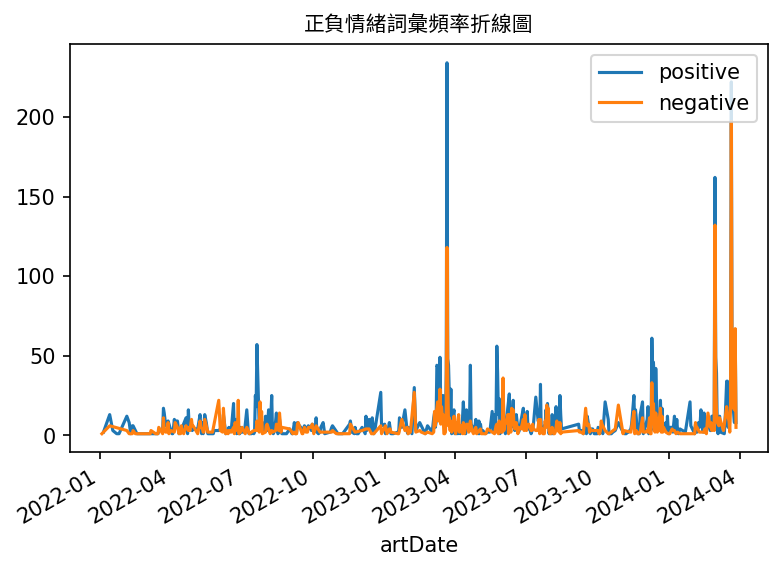

In [110]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

- 可以從圖中看出2023-03~2023-04 正面討論度特別高(WBC日本奪下冠軍，因此討論度特別高)
- 2024-03 因水原一平涉賭一案，因此負面聲量飆升

```Moving average```將時間序列數據平滑化，有助於去除數據中的噪聲，使趨勢更加明顯，使用滾動平均有助於平滑數據，使情緒趨勢更加清晰。
- 去除瞬間噪聲： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
- 強調長期趨勢： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。

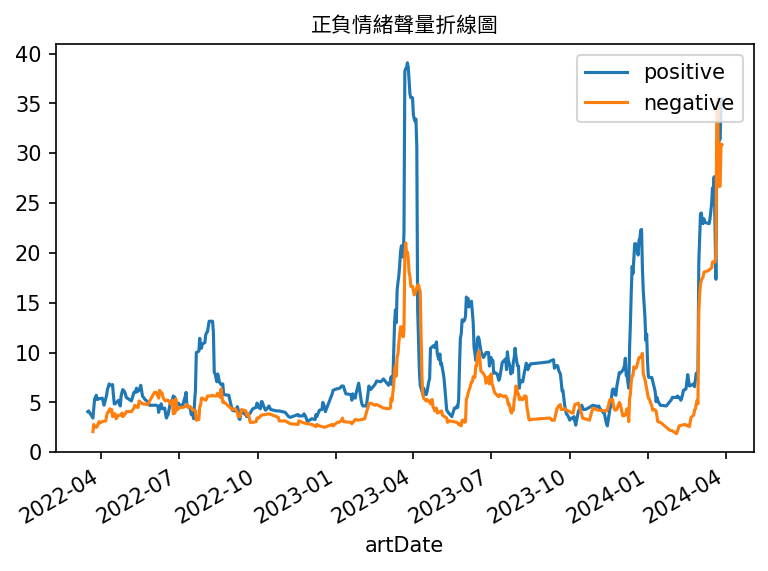

In [111]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  
plt.show()

- 此折線圖和詞彙頻率圖的趨勢相同

### 3.4以文章為單位的情緒分析

In [ ]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

In [ ]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

In [ ]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

In [ ]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

In [115]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2022-01-03,負向,1
1,2022-01-05,正向,1
2,2022-01-13,正向,3
3,2022-01-17,正向,1
4,2022-01-22,正向,1
...,...,...,...
684,2024-03-25,負向,7
685,2024-03-26,正向,11
686,2024-03-26,負向,15
687,2024-03-27,正向,4


### 3.7 情緒代表字

In [ ]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

In [ ]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(10)

In [116]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(10)

,word,sentiments,size
872,打擊,negative,272
383,問題,negative,163
310,受傷,negative,56
1446,禁止,negative,45
982,擊敗,negative,42
1888,震驚,negative,40
427,嚴重,negative,38
885,打破,negative,36
1873,離婚,negative,35
441,垃圾,negative,32


c:\Users\fisha\Anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
c:\Users\fisha\Anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0.5, 1.0, '負向情緒總數')

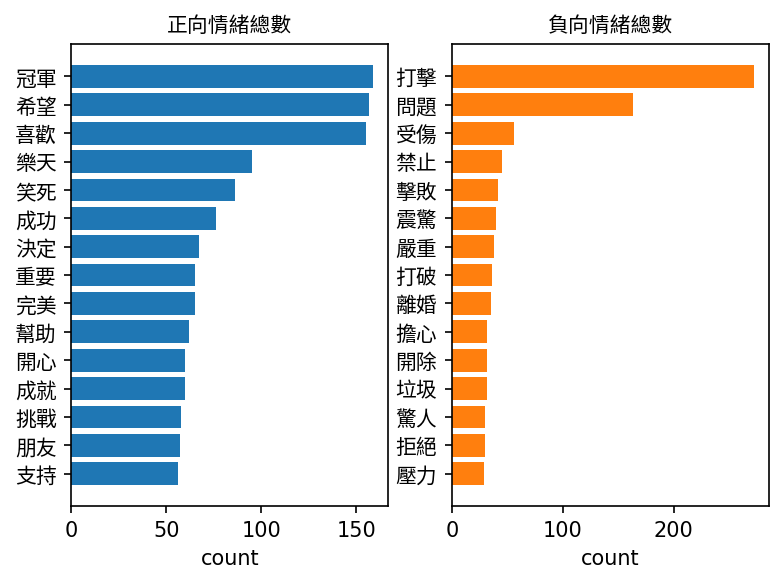

In [107]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 3.8 文字雲
2024-02-01~2024-03-24 在正負情緒聲量折線圖上顯示比較低的分數，用文字雲來看這段時間出現什麼關鍵字

In [102]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")

sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head(3)

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
0,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,如題,負向
1,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,我在王建民那年代開始看大聯盟的,負向
2,https://www.ptt.cc/bbs/Gossiping/M.1641195476....,[問卦]為什麼大聯盟能投100英哩的變那麼多？,2022-01-03,如題，我在王建民那年代開始看大聯盟的，那時候看王建民投95、96麥感覺就超威，後面還\n一個...,那時候看王建民投9596麥感覺就超威,負向


在指定時間，篩選情緒類別"負向"，計算了每個詞彙的出現次數。

In [ ]:
date = "2024-02-01"
end_date = "2024-03-24"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向")

ptt_df_wc = sent_df.loc[mask]
ptt_df_wc


(-0.5, 399.5, 199.5, -0.5)

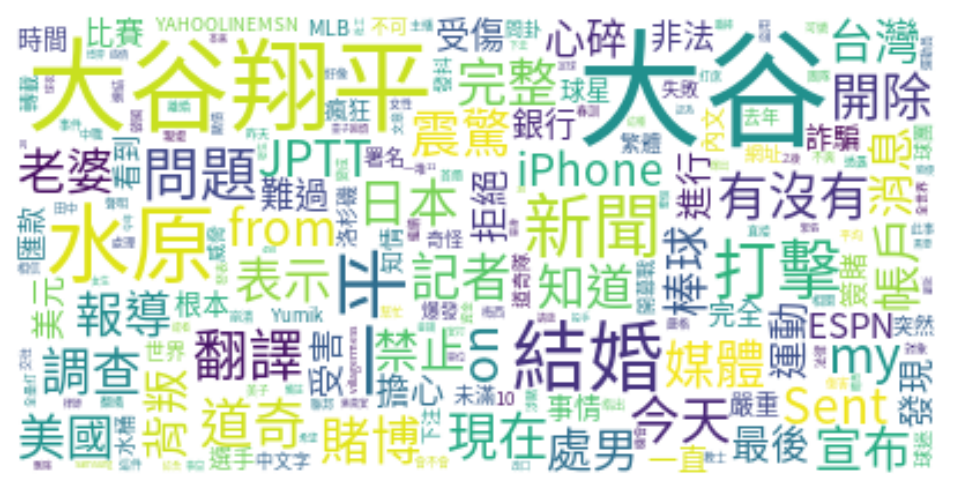

In [117]:
# wordcloud 的 input 是 dictionary
font_path = "./SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

- 關鍵字出現"水原"、"結婚"、"賭博"、"開除"，可能是在說明大谷當時結婚及翻譯水原涉賭相關文章